Dans ce notebook, nous entrainerons le modèle FCN, avec et sans data augmentation.

In [1]:
import cv2
import pandas as pd
import numpy as np
import os, glob
import matplotlib.pyplot as plt

from time import time
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical, Sequence

# Pour la metrique dice
from keras import backend as K

%matplotlib inline

2022-10-10 15:39:57.669121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 15:39:58.203199: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/reda/anaconda3/envs/P8_3/lib/python3.10/site-packages/cv2/../../lib64:
2022-10-10 15:39:58.203222: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-10 15:39:58.268235: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one h

# Préparation des variables

In [2]:
project_path = 'data'
model_path = 'data/model'
checkpoint_path = 'data/checkpoints'

train_input_dir = '../data/train/images'
train_target_dir = '../data/train/masks8'
val_input_dir = '../data/val/images'
val_target_dir = '../data/val/masks8'
test_input_dir = '../data/test/images'
test_target_dir = '../data/test/masks8'

IMG_WIDTH_HEIGHT = (256, 256)
IMG_CHANNELS = 3
batch_size = 7
n_classe = 8

In [3]:
%%time
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))

val_input_path = sorted(glob.glob(val_input_dir + '/*.png'))
val_target_path = sorted(glob.glob(val_target_dir +'/*.png'))

CPU times: user 12.2 ms, sys: 3.81 ms, total: 16 ms
Wall time: 39.8 ms


In [4]:
def dice_coef_loss(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return 1-((2. * intersection + 1) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + 1))

Nous allons créer une dataframe qui contiendra les résultats (score et temps) de nos différents modèles.

In [5]:
data = {'Model': [], "Temps entrainement (minute)": [], "Score_iou": [], "Loss": []}  

df = pd.DataFrame(data)  
  
df

Empty DataFrame
Columns: [Model, Temps entrainement (minute), Score_iou, Loss]
Index: []

# Data Generator

Nous avons récupéré notre data genetor à cette adresse : https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

Le data generator permet de créer des lots de données pour l'entrainement de notre modèle. L'intérêt est de réduire fortement la quantité de mémoire utilisée, que nous pourrions avoir si l'entrainement était effectué directement avec tout le jeu de données (cela crash même le notebook).

In [6]:
class DataGenerator(Sequence):
    """Generate data for Keras
    """

    def __init__(self, input_path, target_path, IMG_WIDTH_HEIGHT, batch_size,
                 n_classes, shuffle):
        self.input_path = input_path
        self.target_path = target_path
        self.targetSize = IMG_WIDTH_HEIGHT
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    # ==== Définie le nombre de lots par époch ==== #
    # Si la longueur peut changer après la construction, l'utilisation 
    # de __len__ est plus approprié.
    # Sans cette fonction, impossible d'avoir len(trainGen).
    # Chaque appel demande un index de lot compris entre 0 et le nombre total 
    # de lots, ce dernier étant spécifié dans la méthode __len__.
    def __len__(self):
        return int(np.floor(len(self.input_path) / float(self.batch_size)))

    # la méthode on_epoch_end est déclenchée une fois au tout début ainsi 
    # qu'à la fin de chaque époque. Si le paramètre shuffle est défini sur 
    # True, nous obtiendrons un nouvel ordre d'exploration à chaque passage 
    # (ou conserverons simplement un schéma d'exploration linéaire dans le cas 
    # contraire).
    def on_epoch_end(self):
        # [0,1,2,3,4... nb_image]
        self.indexes = np.arange(len(self.input_path))

        # [2,4,1,3,0... nb_image]
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    # ==== Obtiens les lots d'images et masques ==== #
    # lorsque le batch correspondant à un index donné est appelé, 
    # le générateur exécute la méthode __getitem__ pour le générer.
    def __getitem__(self, index):
        # Genere batch_size nombre d'ID de ligne DATA 
        currentBatchIdsRow = self.indexes[index * self.batch_size:(index + 1) *
                                          self.batch_size]

        batch_x, batch_y = [], []

        # Itère sur les index
        for i, rowId in enumerate(currentBatchIdsRow):
            # Charge l'image, définis la taille cible, converti en tableau, normalise
            image = img_to_array(
                load_img(f'{self.input_path[i]}',
                         target_size=IMG_WIDTH_HEIGHT)) / 255.
            batch_x.append(image)

            # Chargement du masque original, définition de la taille 
            # cible et conversion en tableau
            mask8 = img_to_array(
                load_img(f'{self.target_path[i]}',
                         color_mode="grayscale",
                         target_size=IMG_WIDTH_HEIGHT))
            
            # to_categorical pour convertir nos étiquettes 
            # numériques stockés dans y en une forme binaire (par exemple, 
            # dans un problème à 6 classes, la troisième étiquette correspond 
            # à [0 0 1 0 0 0]) adaptée à la classification.
            mask = to_categorical(mask8, self.n_classes)
            batch_y.append(mask)

        return np.array(batch_x), np.array(batch_y)

In [7]:
# Génération des données
trainGen = DataGenerator(train_input_path, train_target_path, IMG_WIDTH_HEIGHT, 
                         batch_size, n_classe, shuffle=False)

valGen = DataGenerator(val_input_path, val_target_path, IMG_WIDTH_HEIGHT, 
                       batch_size, n_classe, shuffle=False)

# Initialisation du modèle

In [8]:
IMAGE_ORDERING = 'channels_last'

inputs = Input((256, 256, 3))
s = Lambda(lambda x: x / 255)(inputs)

x = Conv2D(64, (3, 3),
           activation='relu',
           padding='same',
           name='block1_conv1',
           data_format=IMAGE_ORDERING)(s)
x = Conv2D(64, (3, 3),
           activation='relu',
           padding='same',
           name='block1_conv2',
           data_format=IMAGE_ORDERING)(x)
x = MaxPooling2D((2, 2),
                 strides=(2, 2),
                 name='block1_pool',
                 data_format=IMAGE_ORDERING)(x)
f1 = x
# Block 2
x = Conv2D(128, (3, 3),
           activation='relu',
           padding='same',
           name='block2_conv1',
           data_format=IMAGE_ORDERING)(x)
x = Conv2D(128, (3, 3),
           activation='relu',
           padding='same',
           name='block2_conv2',
           data_format=IMAGE_ORDERING)(x)
x = MaxPooling2D((2, 2),
                 strides=(2, 2),
                 name='block2_pool',
                 data_format=IMAGE_ORDERING)(x)
f2 = x

# Block 3
x = Conv2D(256, (3, 3),
           activation='relu',
           padding='same',
           name='block3_conv1',
           data_format=IMAGE_ORDERING)(x)
x = Conv2D(256, (3, 3),
           activation='relu',
           padding='same',
           name='block3_conv2',
           data_format=IMAGE_ORDERING)(x)
x = Conv2D(256, (3, 3),
           activation='relu',
           padding='same',
           name='block3_conv3',
           data_format=IMAGE_ORDERING)(x)
x = MaxPooling2D((2, 2),
                 strides=(2, 2),
                 name='block3_pool',
                 data_format=IMAGE_ORDERING)(x)
f3 = x
pred3 = Conv2DTranspose(n_classe,
                        kernel_size=(16, 16),
                        strides=(16, 16),
                        use_bias=False,
                        data_format=IMAGE_ORDERING)(f3)

# Block 4
x = Conv2D(512, (3, 3),
           activation='relu',
           padding='same',
           name='block4_conv1',
           data_format=IMAGE_ORDERING)(x)
x = Conv2D(512, (3, 3),
           activation='relu',
           padding='same',
           name='block4_conv2',
           data_format=IMAGE_ORDERING)(x)
x = Conv2D(512, (3, 3),
           activation='relu',
           padding='same',
           name='block4_conv3',
           data_format=IMAGE_ORDERING)(x)
x = MaxPooling2D((2, 2),
                 strides=(2, 2),
                 name='block4_pool',
                 data_format=IMAGE_ORDERING)(x)
f4 = x

pred4 = Conv2DTranspose(n_classe,
                        kernel_size=(32, 32),
                        strides=(32, 32),
                        use_bias=False,
                        data_format=IMAGE_ORDERING)(f4)

# Block 5
x = Conv2D(512, (3, 3),
           activation='relu',
           padding='same',
           name='block5_conv1',
           data_format=IMAGE_ORDERING)(x)
x = Conv2D(512, (3, 3),
           activation='relu',
           padding='same',
           name='block5_conv2',
           data_format=IMAGE_ORDERING)(x)
x = Conv2D(512, (3, 3),
           activation='relu',
           padding='same',
           name='block5_conv3',
           data_format=IMAGE_ORDERING)(x)
x = MaxPooling2D((2, 2),
                 strides=(2, 2),
                 name='block5_pool',
                 data_format=IMAGE_ORDERING)(x)
f5 = x
pred5 = Conv2DTranspose(n_classe,
                        kernel_size=(64, 64),
                        strides=(64, 64),
                        use_bias=False,
                        data_format=IMAGE_ORDERING)(f5)

o = Add(name="add")([pred3, pred4, pred5])

o = MaxPooling2D((2, 2),
                 strides=(2, 2),
                 name='final',
                 data_format=IMAGE_ORDERING)(o)
o = (Conv2D(n_classe, (1, 1),
            kernel_initializer='he_normal',
            data_format=IMAGE_ORDERING))(o)

o = (Activation('softmax'))(o)

fcn = Model([inputs], [o])
fcn.summary()

2022-10-10 15:40:01.538222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-10 15:40:01.538418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/reda/anaconda3/envs/P8_3/lib/python3.10/site-packages/cv2/../../lib64:
2022-10-10 15:40:01.538496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/reda/anaconda3/envs/P8_3/lib/python3.10/site-packages/cv2/../../lib64:
2022-10-10 15:40:01.538555: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcu

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

# Entrainement du modèle

Nous allons maintenant entrainer notre modèle.

In [9]:
start = time.time()

fcn.compile(
            optimizer='adam', loss=dice_coef_loss, metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=8)])

earlystopper = [
    ModelCheckpoint(filepath='data/checkpoints/FCN_adam_dice.h5',
                    save_best_only=True,
                    verbose=True),
    EarlyStopping(monitor='val_loss',
                  min_delta=0,
                  patience=2,
                  verbose=0,
                  mode='auto')
]



model_history = fcn.fit(trainGen,
                         validation_data=valGen,
                         workers=8,
                         epochs=10,
                         callbacks=[earlystopper])

end = time.time()

total_time_training = end - start

total_time_training = round(total_time_training / 60, 4)
print("Temps d'entrainement: " + str(total_time_training) + " minutes")

Epoch 1/10
340/340 [==============================] - ETA: 0s - loss: 0.2154 - one_hot_mean_io_u: 0.2342
Epoch 1: val_loss improved from inf to 0.25962, saving model to data/checkpoints/FCN_adam_dice.h5
340/340 [==============================] - 1414s 4s/step - loss: 0.2154 - one_hot_mean_io_u: 0.2342 - val_loss: 0.2596 - val_one_hot_mean_io_u: 0.1942
Epoch 2/10
340/340 [==============================] - ETA: 0s - loss: 0.2139 - one_hot_mean_io_u: 0.2751
Epoch 2: val_loss improved from 0.25962 to 0.22404, saving model to data/checkpoints/FCN_adam_dice.h5
340/340 [==============================] - 1448s 4s/step - loss: 0.2139 - one_hot_mean_io_u: 0.2751 - val_loss: 0.2240 - val_one_hot_mean_io_u: 0.2643
Epoch 3/10
340/340 [==============================] - ETA: 0s - loss: 0.1497 - one_hot_mean_io_u: 0.3740
Epoch 3: val_loss did not improve from 0.22404
340/340 [==============================] - 1455s 4s/step - loss: 0.1497 - one_hot_mean_io_u: 0.3740 - val_loss: 0.2365 - val_one_hot_mea

## Sauvegarde/chargement du modèle

In [10]:
fcn.save('data/model/FCN_adam_dice.h5')

In [11]:
# FCN = keras.models.load_model(
#     'data/model/FCN_adam_dice.h5', custom_objects={"dice_coef_loss": dice_coef_loss})

## Chargement du checkpoint

In [12]:
%%time
# Charge le meilleurs score du modèle à partir du checkpoints
fcn.load_weights('data/checkpoints/FCN_adam_dice.h5')

# Imprime le score du modèle
loss, iou = fcn.evaluate(valGen, verbose=2)
print("Meilleurs score, iou: {:5.2f}%".format(100 * iou))

85/85 - 95s - loss: 0.2240 - one_hot_mean_io_u: 0.2643 - 95s/epoch - 1s/step
Meilleurs score, iou: 26.43%
CPU times: user 11min 41s, sys: 18.4 s, total: 11min 59s
Wall time: 1min 35s


## Sauvegarde des stats du modèle

In [13]:
df = pd.DataFrame({
    'Model': ["FCN_adam_dice"],
    "Temps entrainement (minute)": [total_time_training],
    "Score_iou": [round(100 * iou, 2)],
    "Loss": [round(loss, 4)]
})

df

Model  Temps entrainement (minute)  Score_iou   Loss
0  FCN_adam_dice                      95.9579      26.43  0.224

In [14]:
df.to_csv (r'data/comparatif.csv', index = None, header=True)

## Prediction

In [15]:
%%time
val_preds = fcn.predict(valGen)

85/85 [==============================] - 93s 1s/step


2022-10-10 17:19:09.026445: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1247805440 exceeds 10% of free system memory.


CPU times: user 11min 22s, sys: 23.3 s, total: 11min 46s
Wall time: 1min 33s


# Visualisation

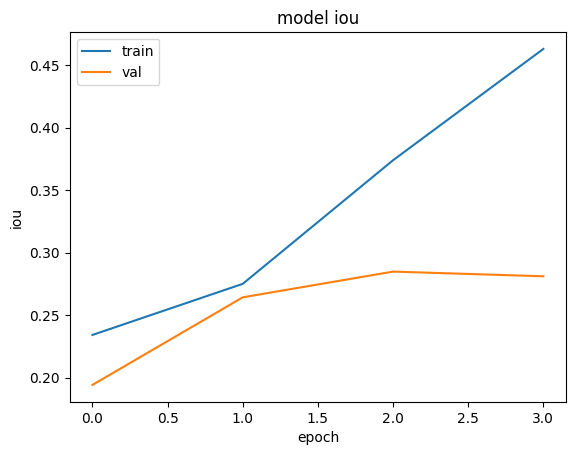

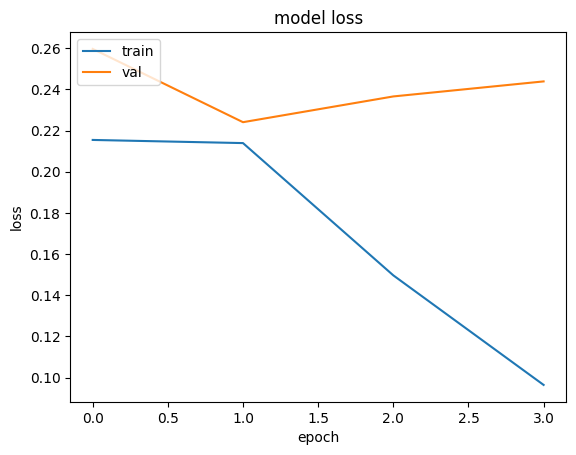

In [16]:
plt.plot(model_history.history['one_hot_mean_io_u'])
plt.plot(model_history.history['val_one_hot_mean_io_u'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

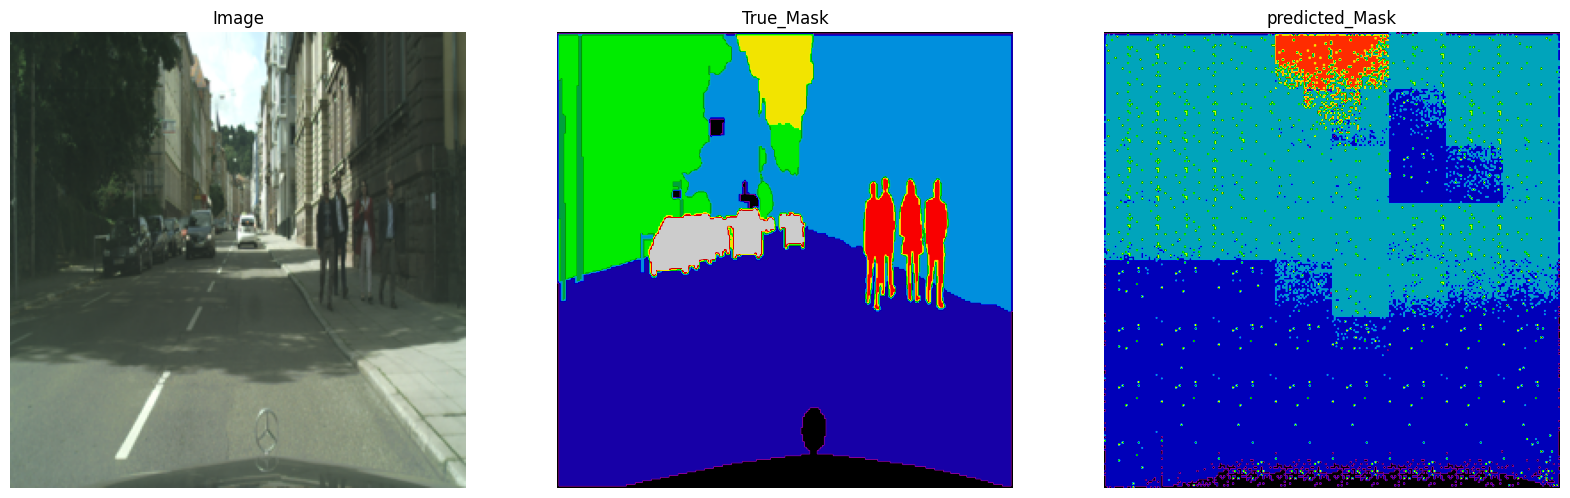

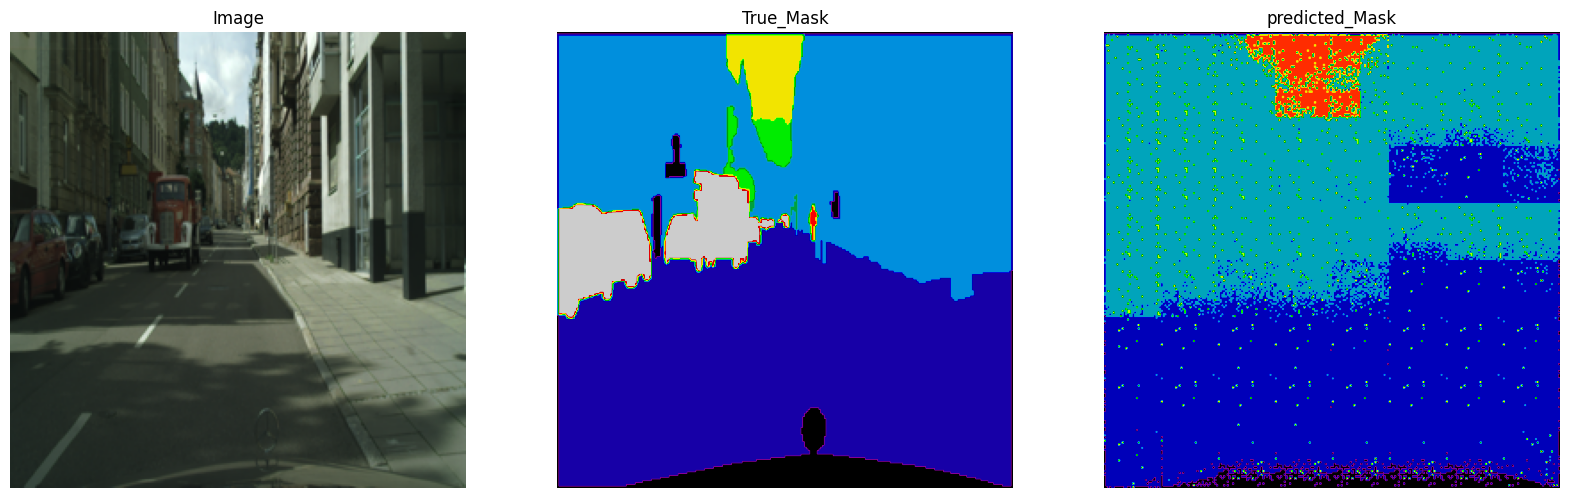

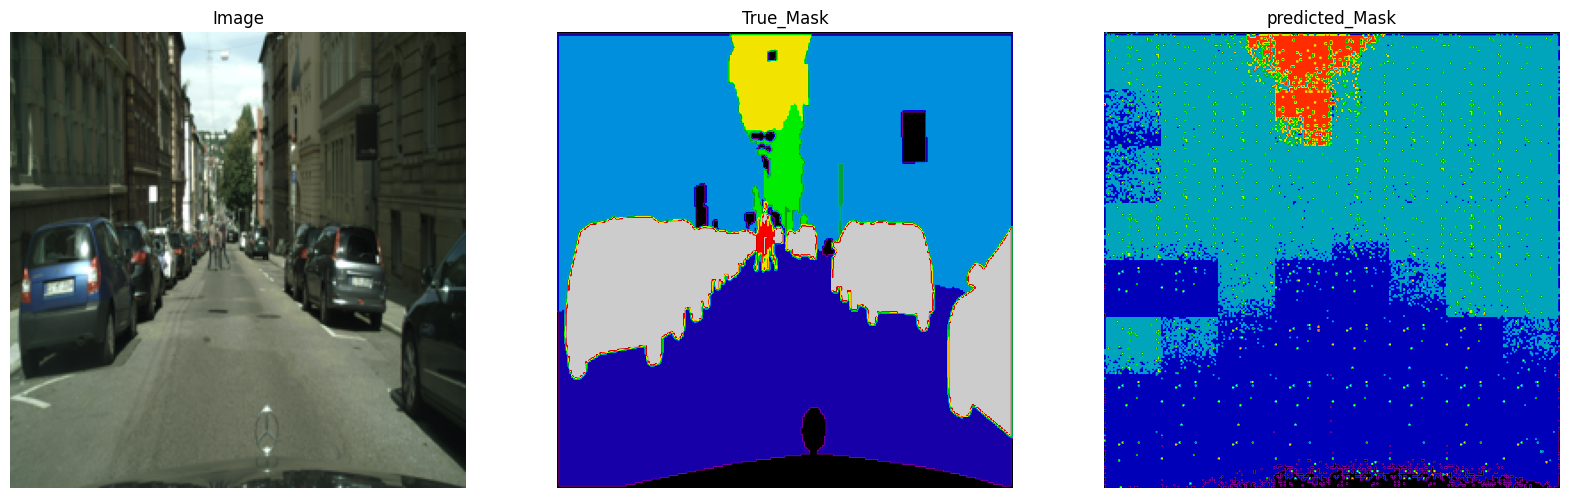

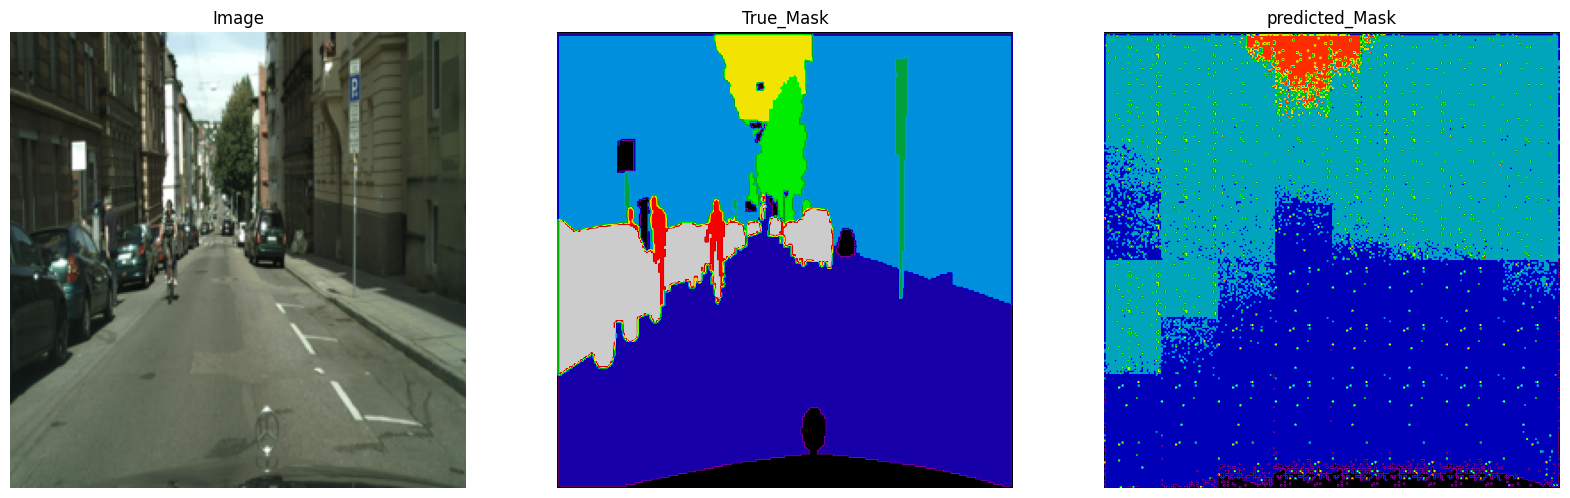

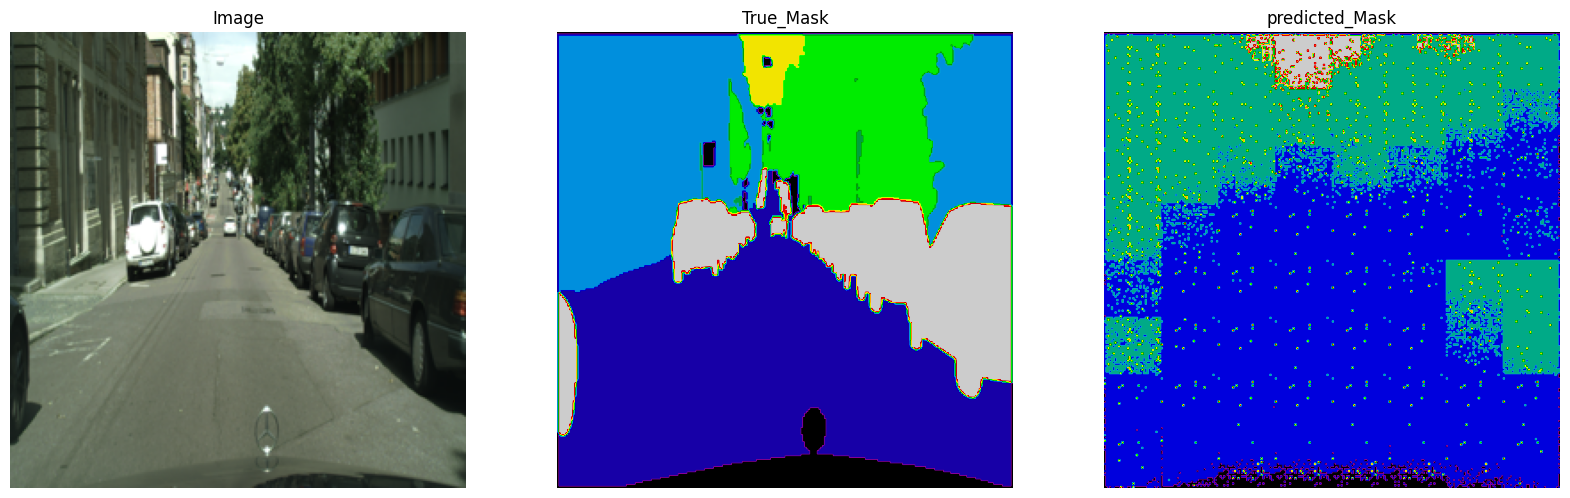

In [17]:
# Display results for validation image #10

for i in range(0,5):
    image = img_to_array(load_img(f'{val_input_path[i]}'))/255.
    mask = img_to_array(load_img(f'{val_target_path[i]}', color_mode = "grayscale"))
    mask = np.squeeze(mask)
    pred_mask = np.argmax(val_preds[i], axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = np.squeeze(pred_mask)

    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Image')
    ax.imshow(image)
    ax.axis('off')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title('True_Mask')
    ax2.imshow(mask, cmap='nipy_spectral')
    ax2.axis('off')

    ax1 = fig.add_subplot(1, 3, 3)
    ax1.set_title('predicted_Mask')
    ax1.imshow(pred_mask, cmap='nipy_spectral')
    ax1.axis('off')

# Avec data augmentation

Nous allons essayer d'obtenir un meilleur score en utilisant les données augmentées que nous avons effectuées dans le notebook Analyse exploratoire.

In [18]:
train_input_dir = '../data/train_augmentation/train/images'
train_target_dir = '../data/train_augmentation/train/masks8'

In [19]:
%%time
train_input_path = sorted(glob.glob(train_input_dir + '/*.png'))
train_target_path = sorted(glob.glob(train_target_dir +'/*.png'))

CPU times: user 33.2 ms, sys: 478 µs, total: 33.7 ms
Wall time: 81.5 ms


In [20]:
# Generate data
trainGen = DataGenerator(train_input_path, train_target_path, IMG_WIDTH_HEIGHT, 
                         batch_size, n_classe, shuffle=False)

In [21]:
start = time.time()

fcn.compile(
            optimizer='adam', loss=dice_coef_loss, metrics=[tf.keras.metrics.OneHotMeanIoU(num_classes=8)])

earlystopper = [
    ModelCheckpoint(filepath='data/checkpoints/FCN_adam_dice_aug.h5',
                    save_best_only=True,
                    verbose=True),
    EarlyStopping(monitor='val_loss',
                  min_delta=0,
                  patience=2,
                  verbose=0,
                  mode='auto')
]



model_history = fcn.fit(trainGen,
                         validation_data=valGen,
                         workers=8,
                         epochs=10,
                         callbacks=[earlystopper])

end = time.time()
total_time_training = end - start

total_time_training = round(total_time_training / 60, 4)

Epoch 1/10
1360/1360 [==============================] - ETA: 0s - loss: 0.0958 - one_hot_mean_io_u_1: 0.4704
Epoch 1: val_loss improved from inf to 0.27411, saving model to data/checkpoints/FCN_adam_dice_aug.h5
1360/1360 [==============================] - 5607s 4s/step - loss: 0.0958 - one_hot_mean_io_u_1: 0.4704 - val_loss: 0.2741 - val_one_hot_mean_io_u_1: 0.2483
Epoch 2/10
1360/1360 [==============================] - ETA: 0s - loss: 0.0779 - one_hot_mean_io_u_1: 0.5025
Epoch 2: val_loss improved from 0.27411 to 0.27030, saving model to data/checkpoints/FCN_adam_dice_aug.h5
1360/1360 [==============================] - 5209s 4s/step - loss: 0.0779 - one_hot_mean_io_u_1: 0.5025 - val_loss: 0.2703 - val_one_hot_mean_io_u_1: 0.2563
Epoch 3/10
1360/1360 [==============================] - ETA: 0s - loss: nan - one_hot_mean_io_u_1: 0.2188
Epoch 3: val_loss did not improve from 0.27030
1360/1360 [==============================] - 5167s 4s/step - loss: nan - one_hot_mean_io_u_1: 0.2188 - val_

## Sauvegarde/chargement du modèle

In [22]:
fcn.save('data/model/FCN_adam_dice_aug.h5')

In [23]:
# FCN = keras.models.load_model(
#     'data/model/FCN_adam_dice_aug.h5', custom_objects={"dice_coef_loss": dice_coef_loss})

## Chargement du checkpoint

In [24]:
%%time
# Charge le meilleur score du modèle à partir du checkpoints
fcn.load_weights('data/checkpoints/FCN_adam_dice_aug.h5')

# Imprime le score du modèle
loss, iou = fcn.evaluate(valGen, verbose=2)
print("Meilleurs score, iou: {:5.2f}%".format(100 * iou))

85/85 - 86s - loss: 0.2703 - one_hot_mean_io_u_1: 0.2563 - 86s/epoch - 1s/step
Meilleurs score, iou: 25.63%
CPU times: user 10min 32s, sys: 16.3 s, total: 10min 49s
Wall time: 1min 26s


## Sauvegarde des stats du modèle

In [25]:
df_fcn_aug = pd.DataFrame({
    'Model': ["FCN_adam_dice_aug"],
    "Temps entrainement (minute)": [total_time_training],
    "Score_iou": [float('{:5.2f}'.format(100 * iou))],
    "Loss": [round(loss, 4)]
})

df = pd.concat([df, df_fcn_aug], ignore_index=True, axis=0)

df

Model  Temps entrainement (minute)  Score_iou    Loss
0      FCN_adam_dice                      95.9579      26.43  0.2240
1  FCN_adam_dice_aug                     351.1985      25.63  0.2703

In [26]:
df.to_csv (r'data/comparatif.csv', index = None, header=True)

## Prediction

In [27]:
%%time
val_preds = fcn.predict(valGen)

85/85 [==============================] - 85s 991ms/step


2022-10-10 23:13:14.936756: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1247805440 exceeds 10% of free system memory.


CPU times: user 10min 21s, sys: 38.8 s, total: 11min
Wall time: 1min 31s


## Visualisation

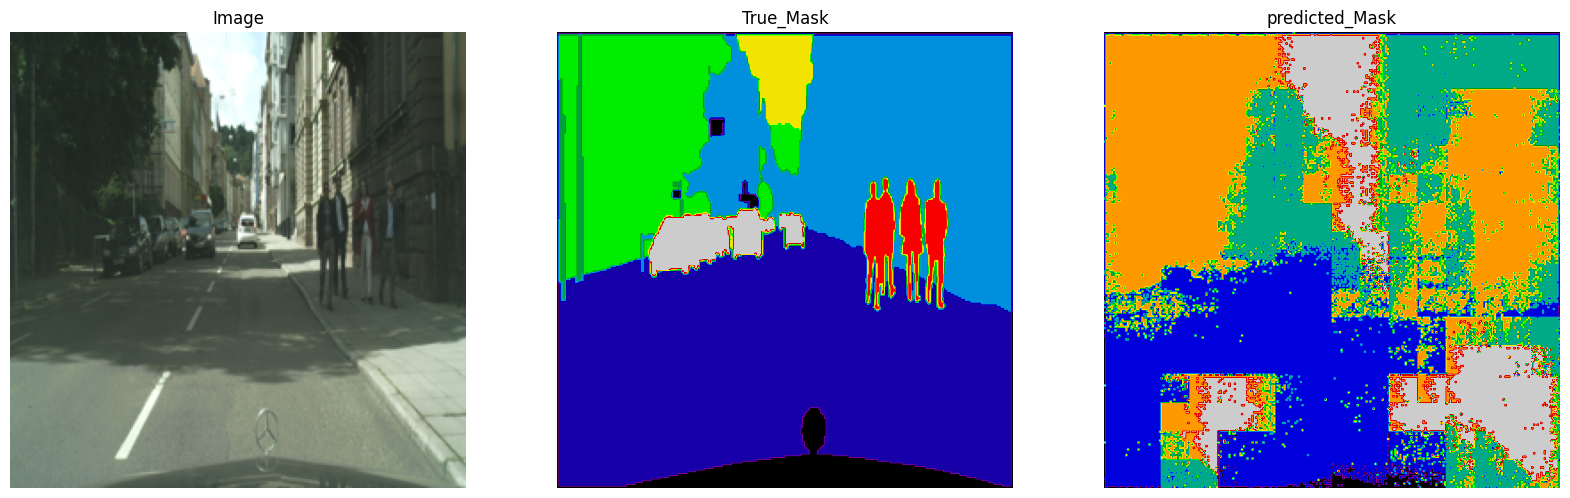

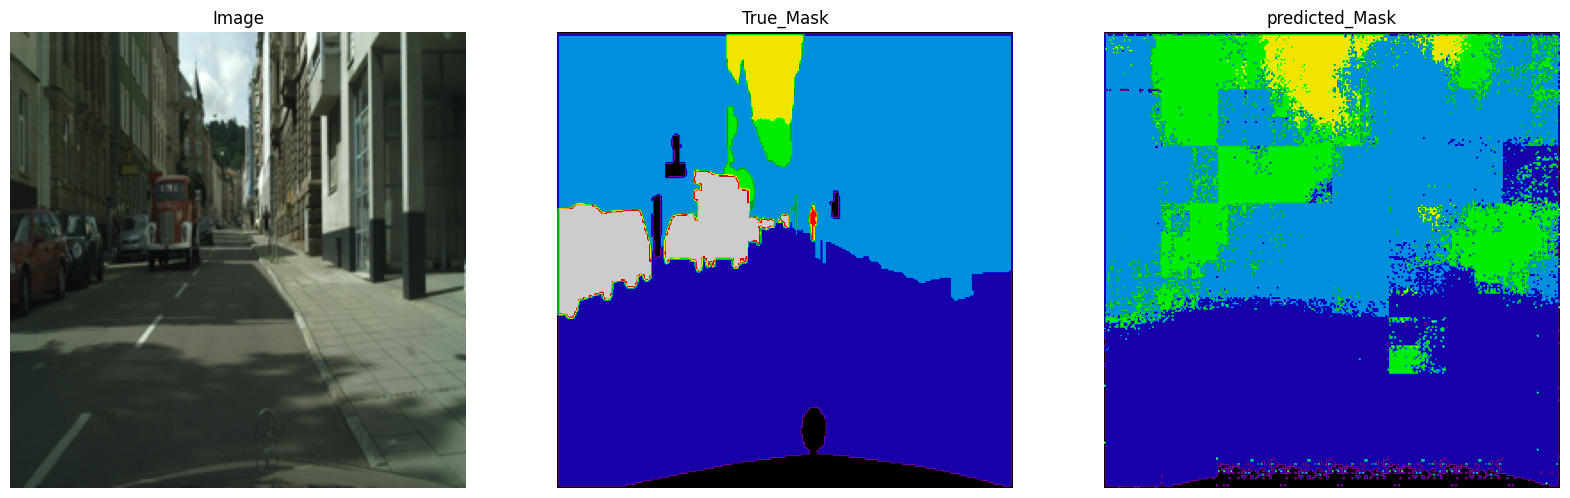

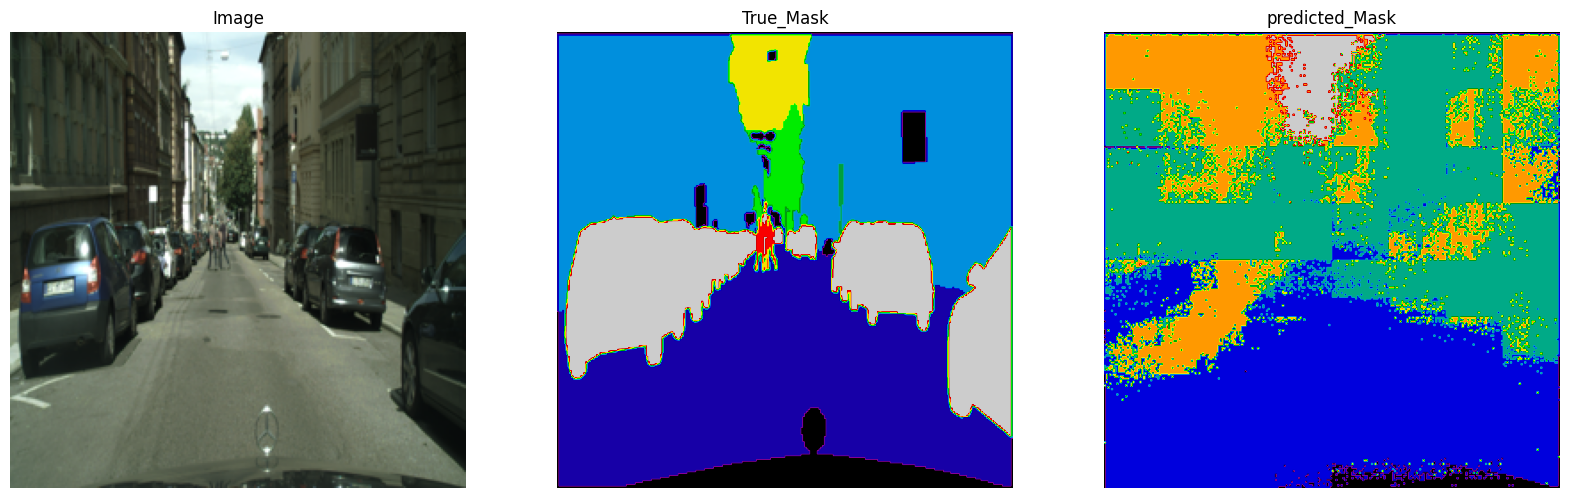

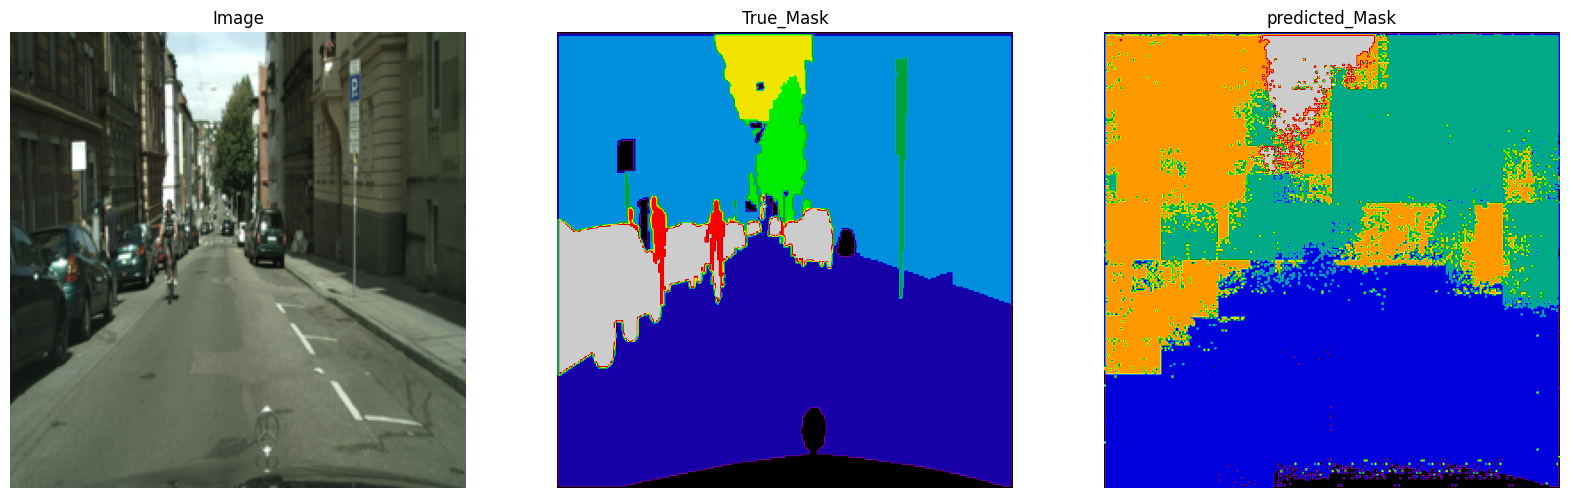

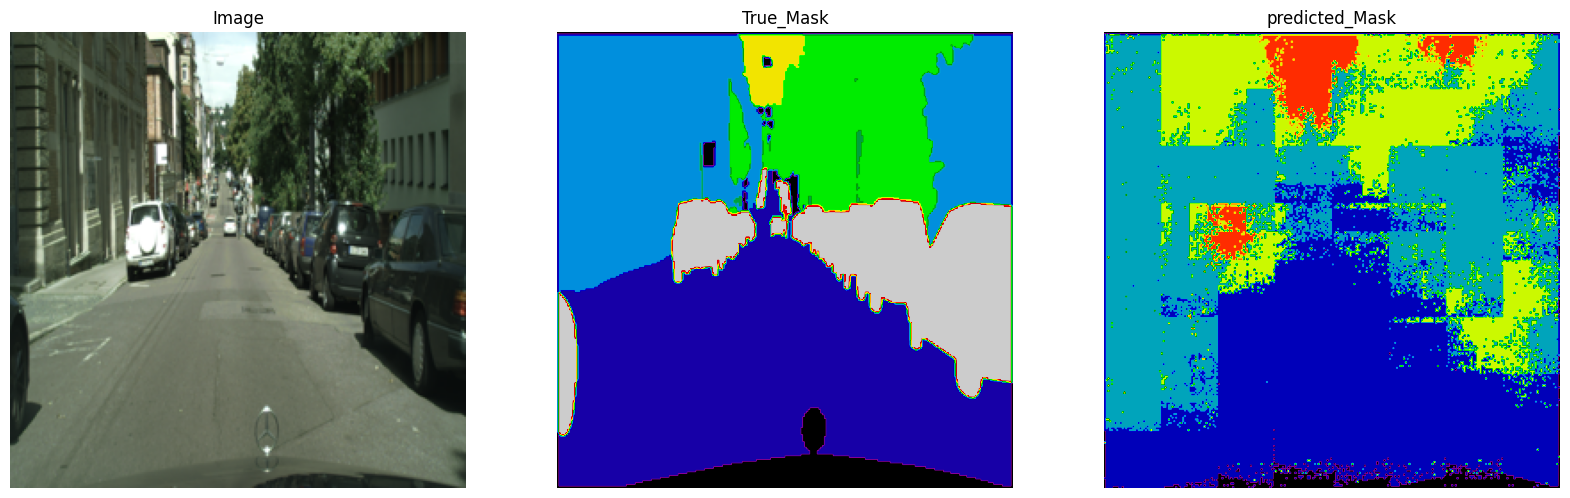

In [28]:
for i in range(0,5):
    image = img_to_array(load_img(f'{val_input_path[i]}'))/255.
    mask = img_to_array(load_img(f'{val_target_path[i]}', color_mode = "grayscale"))
    mask = np.squeeze(mask)
    pred_mask = np.argmax(val_preds[i], axis=-1)
    pred_mask = np.expand_dims(pred_mask, axis=-1)
    pred_mask = np.squeeze(pred_mask)

    
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Image')
    ax.imshow(image)
    ax.axis('off')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_title('True_Mask')
    ax2.imshow(mask, cmap='nipy_spectral')
    ax2.axis('off')

    ax1 = fig.add_subplot(1, 3, 3)
    ax1.set_title('predicted_Mask')
    ax1.imshow(pred_mask, cmap='nipy_spectral')
    ax1.axis('off')